In [1]:
import numpy as np  
import pandas as pd 
import os
import matplotlib.pyplot as plt

import cv2 as cv
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.io.wavfile import read

from tqdm.notebook import tqdm as tqdm

In [2]:
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

In [3]:
TRAIN_PART = 0.125 # part of full data used to train our model 
VAL_PART = 0.2 # part of train data for validation 

In [4]:
train_df = pd.read_csv('/kaggle/input/silero-audio-classifier/train.csv')
_, train_df, _, _ = train_test_split(train_df, train_df['label'].values, test_size = TRAIN_PART, stratify = train_df['label'].values)
train, val, _, _ = train_test_split(train_df, train_df['label'].values, test_size = VAL_PART, stratify = train_df['label'].values)

In [5]:
def to_onehot(label, num_class = 3):
    one_hot = torch.zeros(num_class)
    one_hot[label] = 1
    return one_hot

def read_audio(path):
            sr, wav = read(path)
            assert sr == 16000
            assert len(wav) == 16000 * 3
            assert len(wav.shape) == 1
            return wav
        
def read_audio_norm(path):
            wav = read_audio(path)
            abs_max = np.abs(wav).max()
            wav = wav.astype('float32')
            if abs_max > 0:
                wav *= 1 / abs_max
            return wav

window_size = 0.02
window_stride = 0.01
sample_rate = 16000

n_fft = int(sample_rate * (window_size + 1e-8))
win_length = n_fft
hop_length = int(sample_rate * (window_stride + 1e-8))

kwargs = {
    'n_fft': n_fft,
    'hop_length': hop_length,
    'win_length': n_fft
}

def stft(wav):
    D = librosa.stft(wav,
                     **kwargs)
    mag, phase = librosa.magphase(D)    
    return mag

In [6]:
class SoundDataset(Dataset):
    
    def __init__(self, df, test = False, data_path = '/kaggle/input/silero-audio-classifier/train'):
        super().__init__()
        self.data_path = data_path
        self.df = df
        self.test = test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
                
        label_dict = {'speech':0,
                      'music':1,
                      'noise':2}
        
        wav = read_audio_norm(os.path.join(self.data_path, self.df.iloc[idx].wav_path))
        stft_im = stft(wav)
        stft_im = cv.resize(stft_im, (256,128))
        mag = torch.tensor(stft_im, dtype = torch.float32).unsqueeze(0)
        
        if not self.test:
            label = self.df.iloc[idx].target #label_dict[self.df.iloc[idx].label]
            label_one_hot = to_onehot(label)
            return mag, label_one_hot, torch.tensor(label, dtype = torch.int)
        
        return mag

In [7]:
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 2, 4)
    

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding = 1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding = 1),
            nn.ReLU(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [8]:
def loss_fn(recon_x, x, mu, logvar):
    # BCE = F.binary_cross_entropy(recon_x, x, size_average=True)
    MSE = F.mse_loss(recon_x, x, size_average=True)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD, MSE, KLD

In [9]:
train_dataset = SoundDataset(train)
val_dataset = SoundDataset(val)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
model = VAE(image_channels=1, h_dim = 2048, z_dim = 256)
model = model.to(device)
optimizer = Adam(model.parameters(), lr = 3e-4)

In [12]:
best_val_loss = float('inf')
patience = 3
n_epoch = 15

for i in range(n_epoch):
     
    
    print(f"Training epoch {i}...")
    epoch_train_loss = []
    model.train()
    for x, _, _ in train_loader:
        
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        loss, mse, kld = loss_fn(recon_x, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(mse.item())
 
    mean_train_loss = sum(epoch_train_loss)/len(epoch_train_loss)
    print(f"Train epoch {i} loss is {mean_train_loss}\n\n")
    
    
    print(f"Validation epoch {i}...")
    epoch_val_loss = []
    model.eval()
    with torch.no_grad():
        for x, y, _ in val_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss, mse, kld = loss_fn(recon_x, x, mu, logvar)
            epoch_val_loss.append(mse.item())
    
    mean_val_loss = sum(epoch_val_loss)/len(epoch_val_loss)
    print(f"Val epoch {i} loss is {sum(epoch_val_loss)/len(epoch_val_loss)}\n\n")
    
    if mean_val_loss < best_val_loss:
        patience = 3
        best_val_loss = mean_val_loss
        print(f"Saving model epoch {i}")
        torch.save(model, 'model.pth')
        
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping....")
            break

Training epoch 0...


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Train epoch 0 loss is 2.422599915319081


Validation epoch 0...
Val epoch 0 loss is 2.034275525084166


Saving model epoch 0
Training epoch 1...


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UnFlatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train epoch 1 loss is 1.923521543274998


Validation epoch 1...
Val epoch 1 loss is 1.8863000268134


Saving model epoch 1
Training epoch 2...
Train epoch 2 loss is 1.7975947432551507


Validation epoch 2...
Val epoch 2 loss is 1.78723252710895


Saving model epoch 2
Training epoch 3...
Train epoch 3 loss is 1.7316189814507263


Validation epoch 3...
Val epoch 3 loss is 1.7250672122028385


Saving model epoch 3
Training epoch 4...
Train epoch 4 loss is 1.7000809659444196


Validation epoch 4...
Val epoch 4 loss is 1.6852355114767485


Saving model epoch 4
Training epoch 5...
Train epoch 5 loss is 1.6556417707537041


Validation epoch 5...
Val epoch 5 loss is 1.647027388911381


Saving model epoch 5
Training epoch 6...
Train epoch 6 loss is 1.622433372906276


Validation epoch 6...
Val epoch 6 loss is 1.6498771337705238


Training epoch 7...
Train epoch 7 loss is 1.6081733996750878


Validation epoch 7...
Val epoch 7 loss is 1.6312028136208794


Saving model epoch 7
Training epoch 8...


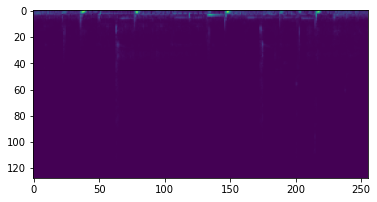

In [13]:
x = train_dataset[13][0]
plt.imshow(x.squeeze(0))

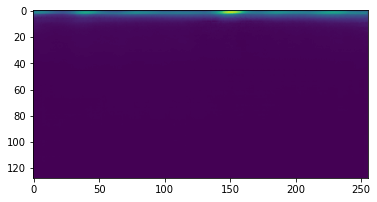

In [14]:
model.to(device)
recon_x, mu, val = model(x.unsqueeze(0).to(device))
plt.imshow(recon_x.cpu().detach().squeeze(0).squeeze(0))

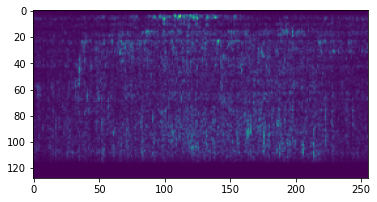

In [15]:
x = train_dataset[45][0]
plt.imshow(x.squeeze(0))

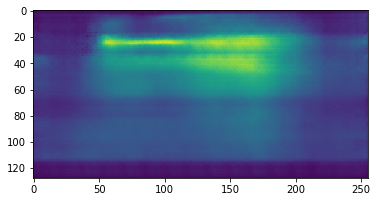

In [16]:
model.to(device)
recon_x, mu, val = model(x.unsqueeze(0).to(device))
plt.imshow(recon_x.cpu().detach().squeeze(0).squeeze(0))